# KMNIST dataset: image classification for Hiragana characters




# Dataset presentation
The KMNIST dataset is a dataset of handwritten Japanese hiragana characters identified as 70000 images with a 28x28 grayscale.

The dataset was created by the National Institute of Informatics (NII) and it is inspired by the structure of the MNIST dataset.
It can be directly downloaded with PyTorch or it can be found on [github](https://github.com/rois-codh/kmnist) in different formats.

The training set is composed of 60000 images, while the test set has 10000 image, and validation set of 10000 images is also included.

In the KMNIST dataset, each image is labeled with a single hiragana character, represented as an integer between 0 and 39. The mapping between the labels and the hiragana characters is given by the first column of the following picture, which is the modern hiragana reprentation

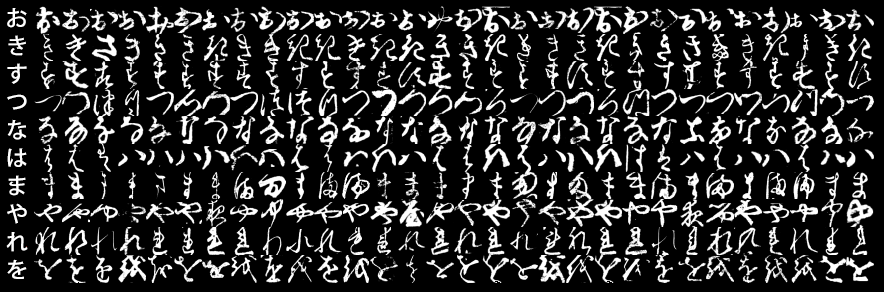

The labels of the 10 classes/categories are coded as follows


0: お

1: き

2: す

3: つ

4: な

5: は

6: ま

7: や

8: れ

9: を



In [ ]:
lab=(u"お",u"き",u'す',u'つ',u'な',u'は',u'ま',u'や',u'れ',u'を')

# Coding and Implementation

Import of the DBN network in PyTorch

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}


In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from sklearn.metrics import confusion_matrix
import torch.nn.functional as functional
from tqdm.notebook import tqdm
import seaborn as sn
import torch
import torchvision as tv
from PIL import Image
from DBN import DBN

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [ ]:
%%capture
kmnist_train = tv.datasets.KMNIST('data/', train=True, download=True,
                                        transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(),
                                                   tv.transforms.Normalize((0.1307,), (0.3081,))]  #mean and std for the KMNIST training set
                                         )) #train=True makes already a train set
                                            #tv.transforms.Normalize((MEAN,),(STD. DEV.,))


kmnist_test = tv.datasets.KMNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor(),
                                         tv.transforms.Normalize((0.1307,), (0.3081,))]
                                ))

0


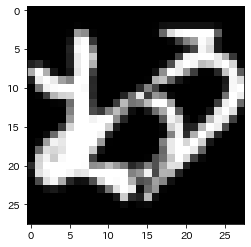

In [ ]:
image, label = kmnist_train[2]
image = np.array(image)
image = image.reshape(28,28)
print(label)
plt.imshow(image, cmap = 'gray') 
plt.show()



Scaling the data dividing by the number of pixels

In [ ]:
kmnist_train.data = (kmnist_train.data.type(torch.FloatTensor)/255) #DIVIDED BY 255 BECAUSE PIXELS RANGE FROM 1 TO 255
kmnist_test.data = (kmnist_test.data.type(torch.FloatTensor)/255)

In [ ]:
kmnist_train.data = kmnist_train.data.to(device)
kmnist_test.data = kmnist_test.data.to(device)

In [ ]:
kmnist_train.targets = kmnist_train.targets.to(device)
kmnist_test.targets = kmnist_test.targets.to(device)

# DBN definition #

A Deep Belief Network is one of the first nonconvolutional models that achieved the training of deep architectures.
It is a Hierarchical Generative Model that consists in a set of layers of latent variables, which are typically binary, to learn multiple levels of representations. There are no intralayer connections, and there are:

*   Undirected Connections between the top two layers;
*   Directed Connections between all the other layers.

Source of the picture: *LeCun, Yann, Yoshua Bengio, and Geoffrey Hinton. "Deep learning." nature 521.7553 (2015): 436-444.*

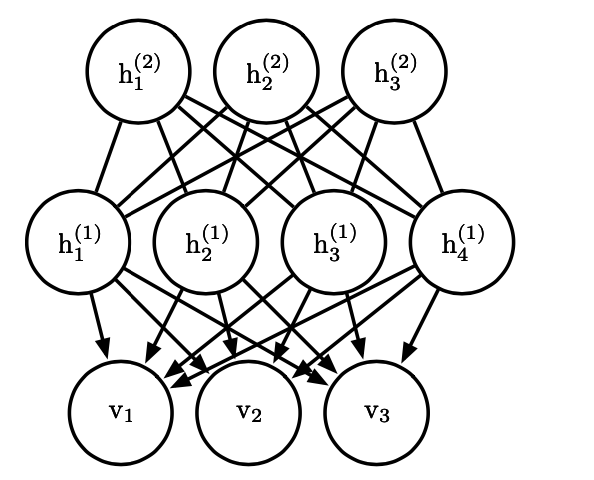



The Architecture for the following DBN will have three hidden layers, for which the number of neurons are:



*  Input Layer: 784 neurons (since the images have 28*28 pixels)
*  First Hidden Layer: 800 neurons
*  Second Hidden Layer: 1500 neurons
*  Third Hidden Layer: 800 neurons

This choice of settings came up after different trials for different parameters value. In particular, the Second Hidden Layer needed more neurons compared to the other two hidden layers because it had bad performances with less neurons.

In [ ]:
#number of neurons for each hidden layer
n1 = 800
n2 = 1500
n3 = 800

In [ ]:
dbn_kmnist = DBN(visible_units=28*28, #number of pixels in the image
                hidden_units=[n1, n2, n3], #arbitrary, a possible architecture, hidden_units=[1st hidden neurons, 2nd, 3rd,...]
                                              #maybe some simulations can help to calibrate this parameters
                k=1, #sampling steps
                learning_rate=0.05, 
                learning_rate_decay=False, #
                initial_momentum=0.6, #momentum parameter to speed up convergence
                final_momentum=0.95,
                weight_decay=0.0001, #regularization parameter
                xavier_init=False, 
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

## Training

The number of epochs has been set at 50 since it leads to a sufficiently low error value, but it could have been chosen with the use of cross validation or grid-search.

A batch size of 64 seems appropriate since it is large enough and it is also a power of two, which is useful in order to take advantage of the GPU computation at its best.


In [ ]:
num_epochs = 50 
batch_size = 64

dbn_kmnist.train_static(
    kmnist_train.data,
    kmnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2363     |0.0575       |564.0679   |7.6487     |
|20    |1.1471     |0.0502       |526.8641   |6.4833     |
|30    |1.1243     |0.0482       |519.2074   |6.9270     |
|40    |1.1142     |0.0473       |515.8438   |6.0685     |
|50    |1.1081     |0.0456       |513.5121   |6.3063     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8124     |0.0241       |461.9006   |4.6845     |
|20    |0.7577     |0.0227       |450.7970   |4.9589     |
|30    |0.7482     |0.0217       |455.7350   |4.7771     |
|40    |0.7435     |0.0223       |459.3575   |5.4933     |
|50    |0.7421     |0.0213       |465.6638   |4.5736     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.4056     |0.0159       |485.6889   |5.3262     |
|20    |0.3488     |0.0129       |442.8355   |4.839

# Visualizing receptive fields

It's useful to visualize the learned weight by plotting some weights in pictures with the size of the KMNIST images in order to check what aspects of the pciture each weight is processing.
A threshold is also applied to make the plots less noisier.

Since values in different weigths could have different ranges, the `MinMaxScaler` from Scikit-Learn will be applied to have the same scaled range for every receptive fields.

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold) #threshold to make picture better
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100 #number of receptive fields
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

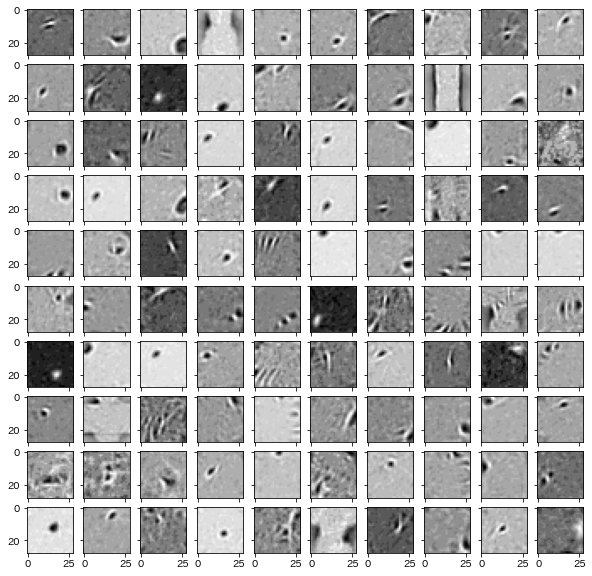

In [ ]:
learned_weights_layer_1 = get_weights(dbn_kmnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

A projection of each of the vectors in a space of dimensionality `784` (`28`x`28`) is needed in order to visualize them as images.

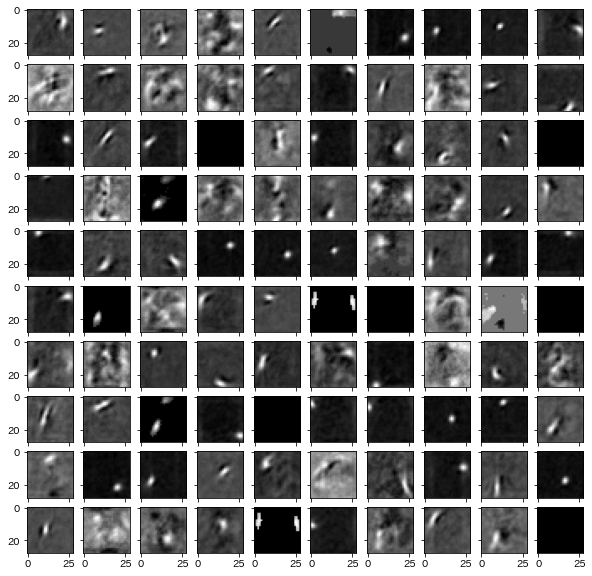

In [ ]:
learned_weights_layer_1 = get_weights(dbn_kmnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_kmnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

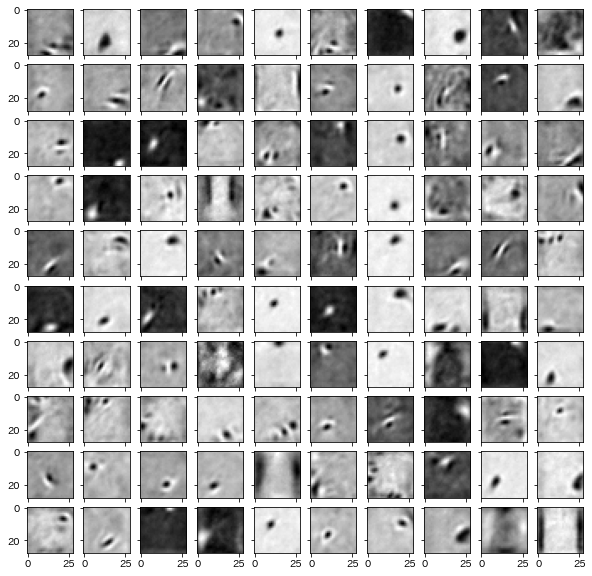

In [ ]:
learned_weights_layer_1 = get_weights(dbn_kmnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_kmnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_kmnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

# Linear Read-out #


For each Hidden Layer, a linear read-out will be applied in order to obtain a supervised method that gives labels of each character. Then, it's possible to evaluate performances of each Hidden Layer in the classification task.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_kmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(kmnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
layer_size = dbn_kmnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_kmnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_kmnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

The Stochastic Gradient Descent is used as optimization algorithm because there is a large amount of data.

The number of epochs is set to 2500 since this lead to a sufficiently low loss function value for each layer.



In [ ]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 2500

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = kmnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_layer_1)

epoch :   1/2500, loss = 2.2823
epoch : 101/2500, loss = 0.7980
epoch : 201/2500, loss = 0.6246
epoch : 301/2500, loss = 0.5465
epoch : 401/2500, loss = 0.4991
epoch : 501/2500, loss = 0.4660
epoch : 601/2500, loss = 0.4410
epoch : 701/2500, loss = 0.4211
epoch : 801/2500, loss = 0.4046
epoch : 901/2500, loss = 0.3907
epoch : 1001/2500, loss = 0.3787
epoch : 1101/2500, loss = 0.3682
epoch : 1201/2500, loss = 0.3588
epoch : 1301/2500, loss = 0.3504
epoch : 1401/2500, loss = 0.3428
epoch : 1501/2500, loss = 0.3358
epoch : 1601/2500, loss = 0.3295
epoch : 1701/2500, loss = 0.3236
epoch : 1801/2500, loss = 0.3181
epoch : 1901/2500, loss = 0.3130
epoch : 2001/2500, loss = 0.3083
epoch : 2101/2500, loss = 0.3038
epoch : 2201/2500, loss = 0.2997
epoch : 2301/2500, loss = 0.2957
epoch : 2401/2500, loss = 0.2920


In [ ]:
train_linear(linear2, hidden_repr_layer_2)

epoch :   1/2500, loss = 2.3139
epoch : 101/2500, loss = 0.7956
epoch : 201/2500, loss = 0.6309
epoch : 301/2500, loss = 0.5562
epoch : 401/2500, loss = 0.5102
epoch : 501/2500, loss = 0.4776
epoch : 601/2500, loss = 0.4526
epoch : 701/2500, loss = 0.4325
epoch : 801/2500, loss = 0.4156
epoch : 901/2500, loss = 0.4012
epoch : 1001/2500, loss = 0.3886
epoch : 1101/2500, loss = 0.3775
epoch : 1201/2500, loss = 0.3675
epoch : 1301/2500, loss = 0.3584
epoch : 1401/2500, loss = 0.3502
epoch : 1501/2500, loss = 0.3426
epoch : 1601/2500, loss = 0.3356
epoch : 1701/2500, loss = 0.3291
epoch : 1801/2500, loss = 0.3231
epoch : 1901/2500, loss = 0.3174
epoch : 2001/2500, loss = 0.3121
epoch : 2101/2500, loss = 0.3071
epoch : 2201/2500, loss = 0.3024
epoch : 2301/2500, loss = 0.2979
epoch : 2401/2500, loss = 0.2937


In [ ]:
train_linear(linear3, hidden_repr_layer_3)

epoch :   1/2500, loss = 2.3119
epoch : 101/2500, loss = 0.7615
epoch : 201/2500, loss = 0.5893
epoch : 301/2500, loss = 0.5127
epoch : 401/2500, loss = 0.4664
epoch : 501/2500, loss = 0.4342
epoch : 601/2500, loss = 0.4100
epoch : 701/2500, loss = 0.3907
epoch : 801/2500, loss = 0.3749
epoch : 901/2500, loss = 0.3616
epoch : 1001/2500, loss = 0.3500
epoch : 1101/2500, loss = 0.3400
epoch : 1201/2500, loss = 0.3310
epoch : 1301/2500, loss = 0.3231
epoch : 1401/2500, loss = 0.3158
epoch : 1501/2500, loss = 0.3092
epoch : 1601/2500, loss = 0.3032
epoch : 1701/2500, loss = 0.2977
epoch : 1801/2500, loss = 0.2925
epoch : 1901/2500, loss = 0.2877
epoch : 2001/2500, loss = 0.2833
epoch : 2101/2500, loss = 0.2791
epoch : 2201/2500, loss = 0.2752
epoch : 2301/2500, loss = 0.2715
epoch : 2401/2500, loss = 0.2680


In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(kmnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

The evaluation metric used to evaluate the performances is the Accuracy, which gives the frequency of correctly classified examples.

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, kmnist_test.targets) #first layer

0.8149999976158142

In [ ]:
compute_accuracy(predictions_test2, kmnist_test.targets) #second layer

0.8154000043869019

In [ ]:
compute_accuracy(predictions_test3, kmnist_test.targets) #third layer

0.8285999894142151

# FeedForward Network (FFNN)

It is useful to define a Feed-Forward Network that has the same structure of the previously defined DBN to make comparisons, since they are very different models.

Unlike DBN, a Feed-Forward Network has only unidirectional link from the input to the output, without feedback connections. 

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(n1, n2, n3).to(device)

## Train

In [ ]:
train_linear(ffnn, kmnist_train.data.reshape((60000, 784)))

epoch :   1/2500, loss = 2.3040
epoch : 101/2500, loss = 1.4005
epoch : 201/2500, loss = 0.7344
epoch : 301/2500, loss = 0.5504
epoch : 401/2500, loss = 0.4615
epoch : 501/2500, loss = 0.3919
epoch : 601/2500, loss = 0.3404
epoch : 701/2500, loss = 0.3018
epoch : 801/2500, loss = 0.2685
epoch : 901/2500, loss = 0.2393
epoch : 1001/2500, loss = 0.2147
epoch : 1101/2500, loss = 0.1948
epoch : 1201/2500, loss = 0.1826
epoch : 1301/2500, loss = 0.1551
epoch : 1401/2500, loss = 0.1394
epoch : 1501/2500, loss = 0.1239
epoch : 1601/2500, loss = 5.4914
epoch : 1701/2500, loss = 0.1468
epoch : 1801/2500, loss = 0.1139
epoch : 1901/2500, loss = 0.0964
epoch : 2001/2500, loss = 0.0838
epoch : 2101/2500, loss = 0.0737
epoch : 2201/2500, loss = 0.0651
epoch : 2301/2500, loss = 0.0577
epoch : 2401/2500, loss = 0.0513


## Predictions and Performance Evaluation (Accuracy)

In [ ]:
predictions_ffnn = ffnn(kmnist_test.data.reshape((10000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, kmnist_test.targets)

0.8937000036239624

The Accuracy is a bit higher compared to the DBN, which has an Accuracy of 83% on the Third Hidden Layer. 

This network will be also used for other comparisons in Adversarial Attacks later.

# Unsupervised Learning: Hierarchical Structure analysis



Clustering consists in grouping observations that have similar characteristics. Hierarchical Agglomerative Methods give a representation of the underlying structure by visualizing how much each category is similar to the others, since it sequentially groups the observations and creates a representation of the whole Hierarchy similarity between categories.

In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = kmnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)

In [ ]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In the next steps, there will be an application of Hierarchical Structure with the comparison of different Linkage Methods: each of them will lead to different clusters.

Source : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

## Dendrogram with the Complete Method



Distances between observations are computed as

 $d(u,v)=max(dist(u[i],v[j]))$

In [ ]:
def plot_dendrogram_complete(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=lab)
  ax.set_title(title)

### Hidden Layer 1

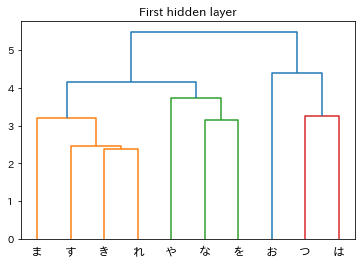

In [ ]:
plot_dendrogram_complete(mean_hidd_repr_matrix_1, "First hidden layer") #at the first layer, the network identifies these clusters between these numbers

There are 4 main different clusters of categories.

### Hidden Layer 2

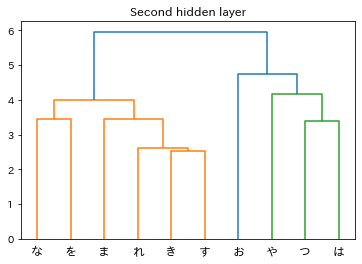

In [ ]:
plot_dendrogram_complete(mean_hidd_repr_matrix_2, "Second hidden layer") #at the second layer, the network identifies these clusters between these numbers

There are 3 main different clusters of categories.

### Hidden Layer 3

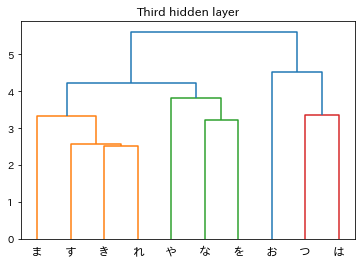

In [ ]:
plot_dendrogram_complete(mean_hidd_repr_matrix_3, "Third hidden layer") #at the third layer, the network identifies these clusters between these numbers

There are 4 main different clusters of categories, and it is identical to the
First Hidden Layer.

## Dendrogram with the Average Method


Distances between observations are computed as

 $d(u,v)=\sum_{ij} \frac{d(u[i],v[j])}{(|u|*|v|)}$

In [ ]:
def plot_dendrogram_avg(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="average")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=lab)
  ax.set_title(title)

### Hidden Layer 1

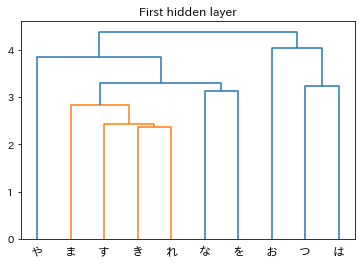

In [ ]:
plot_dendrogram_avg(mean_hidd_repr_matrix_1, "First hidden layer") #at the first layer, the network identifies these clusters between these numbers

There are 2 main different clusters of categories.

### Hidden Layer 2

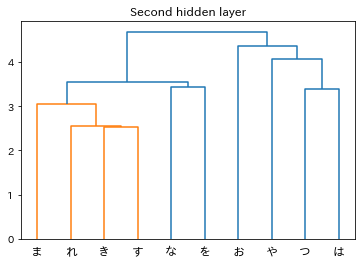

In [ ]:
plot_dendrogram_avg(mean_hidd_repr_matrix_2, "Second hidden layer") #at the second layer, the network identifies these clusters between these numbers

There are 2 main different clusters of categories.

### Hidden Layer 3

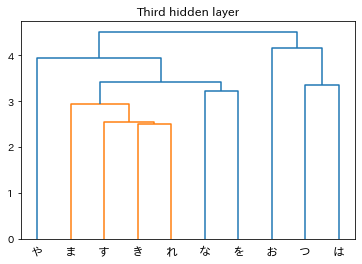

In [ ]:
plot_dendrogram_avg(mean_hidd_repr_matrix_3, "Third hidden layer") #at the third layer, the network identifies these clusters between these numbers

There are 2 main different clusters of categories, which are the same as the First Hidden Layer clusters.

## Dendrogram with the Single Method


Distances between observations are computed as

 $d(u,v)=min(dist(u[i],v[j]))$

In [ ]:
def plot_dendrogram_single(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="single")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels=lab)
  ax.set_title(title)

### Hidden Layer 1

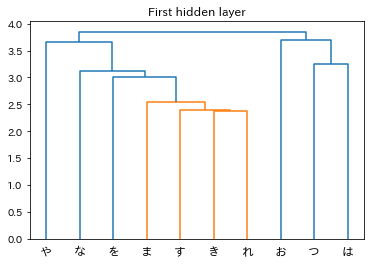

In [ ]:
plot_dendrogram_single(mean_hidd_repr_matrix_1, "First hidden layer") #at the first layer, the network identifies these clusters between these numbers

There are 2 main different clusters of categories.

### Hidden Layer 2

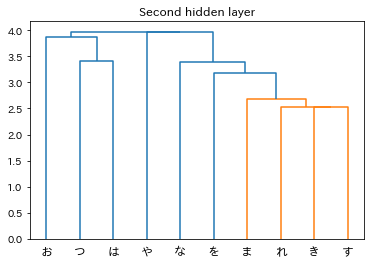

In [ ]:
plot_dendrogram_single(mean_hidd_repr_matrix_2, "Second hidden layer") #at the second layer, the network identifies these clusters between these numbers

There are 2 main different clusters of categories.

### Hidden Layer 3

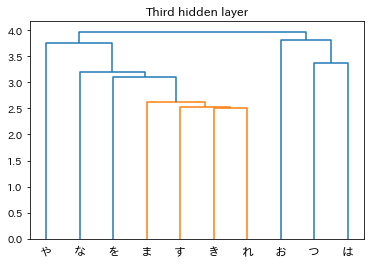

In [ ]:
plot_dendrogram_single(mean_hidd_repr_matrix_3, "Third hidden layer") #at the third layer, the network identifies these clusters between these numbers

There are 2 main different clusters of categories.

Again, there are 2 main categories which are the same in the First and in the Third Hidden Layer.

It's worth to note that clusters identified by the First Hidden Layer and clusters identified by the Third Hidden Layer are always exactly the same, even when changing the linkage method.

# Model Evaluation

First, some Random Noise is injected in order to obtain Psychometric curves and the Confusion Matrix. This is done to evalute the model performance when it is handling data with noise.

In [ ]:
def inject_noise(kmnist_data, noise_level):
  random_gaussian_tensor = torch.randn(kmnist_data.shape, device = device)*noise_level
  return kmnist_data + random_gaussian_tensor

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  kmnist_test_with_noise = inject_noise(kmnist_test.data, noise_level)  # creeation of noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(kmnist_test_with_noise, 0, device)  # DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # Use of the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, kmnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, kmnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, kmnist_test.targets)

  predictions_ffnn_noisy = ffnn(kmnist_test_with_noise.reshape((10000, 784)))  # feed-forward network 
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, kmnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

Here, some values for the noise level are evaluated, but it's possible to increase or decrease them, or use different values.

In [ ]:
noise_lev = np.arange(0.1, 0.5 , 0.1)
for i in noise_lev:
  acc = get_accuracy_values_at_noise_level(i);
  print("-----------------------------------------")
  print("With a noise level of %.2f"%i)
  print("Accuracy of H1 read-out: %.3f" % acc[0])
  print("Accuracy of H2 read-out: %.3f" % acc[1])
  print("Accuracy of H3 read-out: %.3f" % acc[2])
  print("Accuracy of FF network : %.3f" % acc[3])

-----------------------------------------
With a noise level of 0.10
Accuracy of H1 read-out: 0.808
Accuracy of H2 read-out: 0.810
Accuracy of H3 read-out: 0.826
Accuracy of FF network : 0.888
-----------------------------------------
With a noise level of 0.20
Accuracy of H1 read-out: 0.782
Accuracy of H2 read-out: 0.808
Accuracy of H3 read-out: 0.820
Accuracy of FF network : 0.866
-----------------------------------------
With a noise level of 0.30
Accuracy of H1 read-out: 0.752
Accuracy of H2 read-out: 0.795
Accuracy of H3 read-out: 0.807
Accuracy of FF network : 0.823
-----------------------------------------
With a noise level of 0.40
Accuracy of H1 read-out: 0.708
Accuracy of H2 read-out: 0.778
Accuracy of H3 read-out: 0.790
Accuracy of FF network : 0.767


## Psychometric Curves

The representation of Psychometric Curves will show how much the Accuracy changes with more Noise level, for each Hidden Layer.

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise comparison ")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

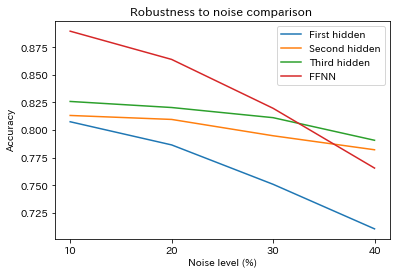

In [ ]:
plot_noise_robustness_curves(noise_lev)

## Confusion Matrices

Now, another function based on the previous one is created, and this time it will return the predictions value. These are needed in order to obtain the confusion matrix for each hidden layer predictions, with different noise levels that were already specified for the computation of Psychometric Curves.

In [ ]:
def get_y_values_at_noise_level(noise_level):

  kmnist_test_with_noise = inject_noise(kmnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(kmnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  predictions_ffnn_noisy = ffnn(kmnist_test_with_noise.reshape((10000, 784)))  # feed-forward network 

  return predictions_first_hidden_noisy, predictions_second_hidden_noisy, predictions_third_hidden_noisy, predictions_ffnn_noisy

# Definition of the label's classes
classes = lab  

### Hidden Layer 1

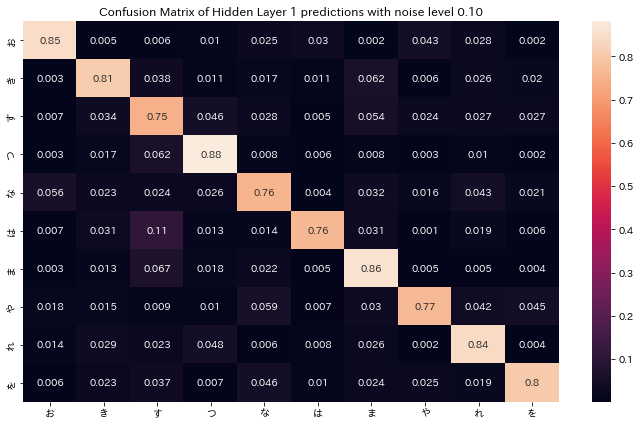

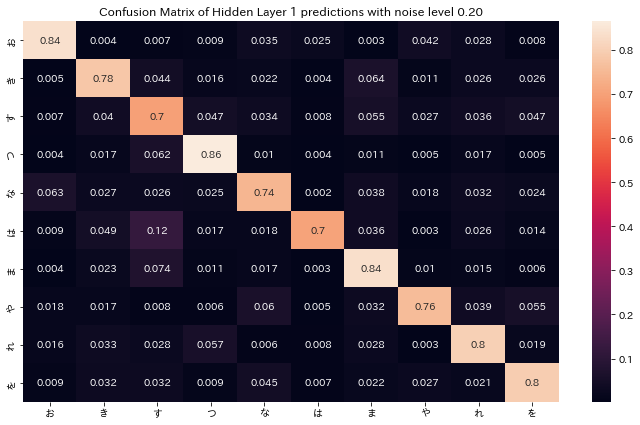

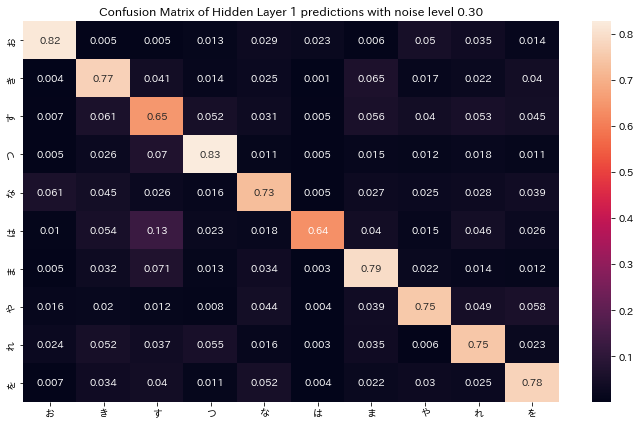

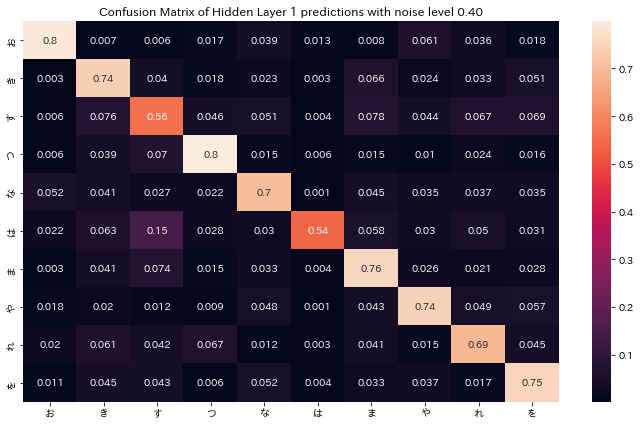

In [ ]:
for i in noise_lev:
  y_true = kmnist_test.targets.cpu().numpy()
  y_pred = get_y_values_at_noise_level(i)[0]
  h1_predictions_indices = y_pred.max(axis=1).indices.cpu().numpy()   # convert probabilities to indices

  cf_mat = confusion_matrix(y_true, h1_predictions_indices)
  cf_mat_df = pd.DataFrame(cf_mat/np.sum(cf_mat) *10, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  plt.title("Confusion Matrix of Hidden Layer 1 predictions with noise level "+ str("{:.2f}".format(i)))
  sn.heatmap(cf_mat_df, annot=True)

### Hidden Layer 2

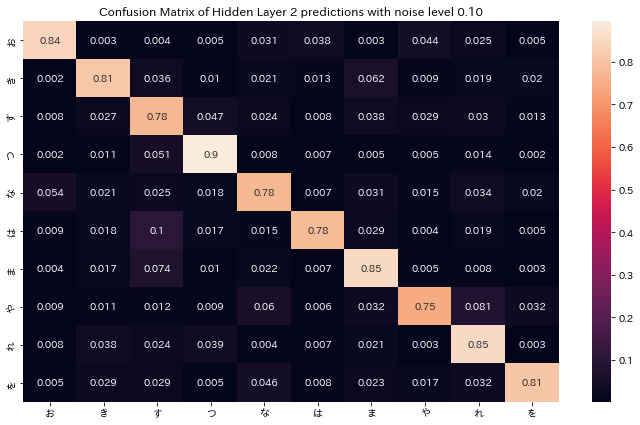

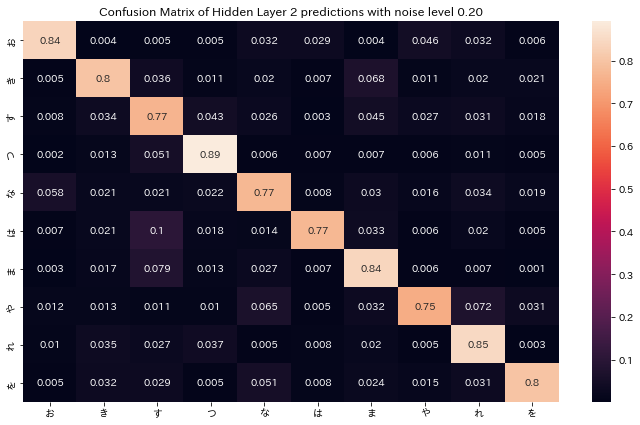

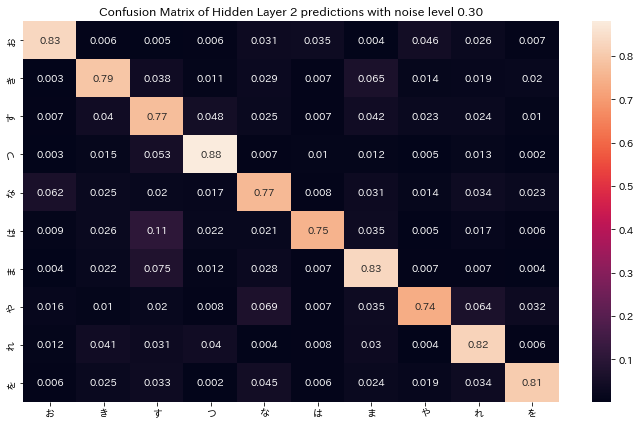

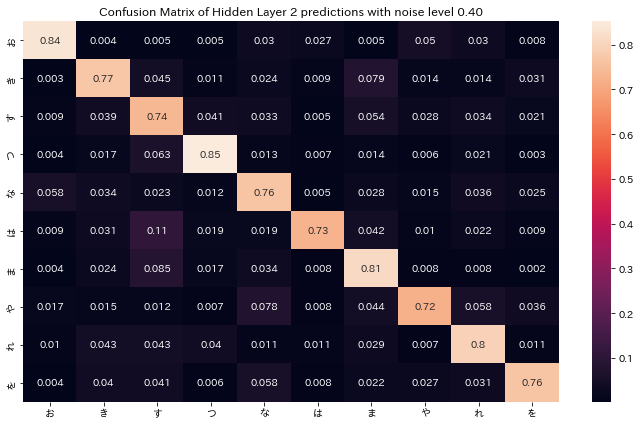

In [ ]:
for i in noise_lev:
  y_true = kmnist_test.targets.cpu().numpy()
  y_pred = get_y_values_at_noise_level(i)[1]
  h2_predictions_indices = y_pred.max(axis=1).indices.cpu().numpy()  # convert probabilities to indices

  cf_mat = confusion_matrix(y_true, h2_predictions_indices)
  cf_mat_df = pd.DataFrame(cf_mat/np.sum(cf_mat) *10, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  plt.title("Confusion Matrix of Hidden Layer 2 predictions with noise level "+ str("{:.2f}".format(i)))
  sn.heatmap(cf_mat_df, annot=True)

### Hidden Layer 3

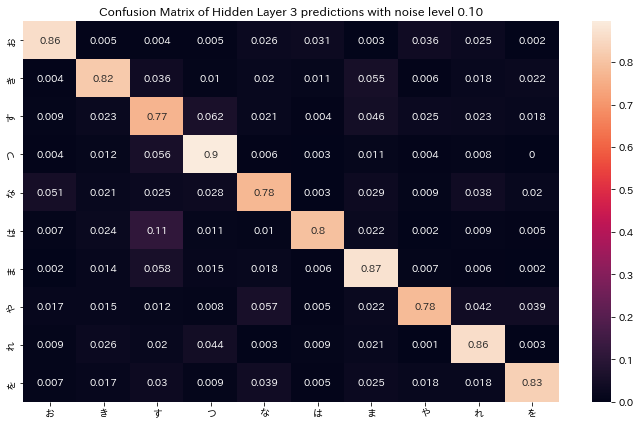

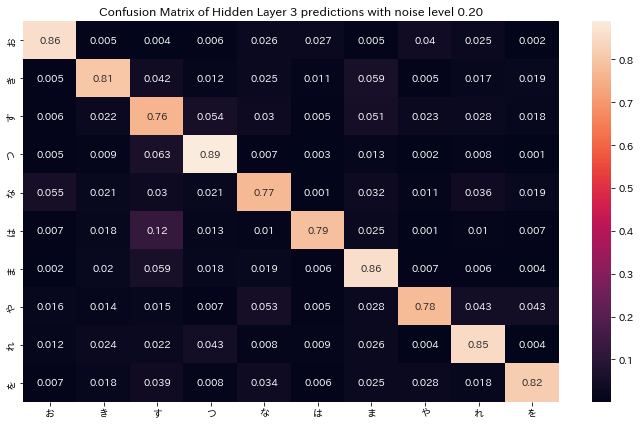

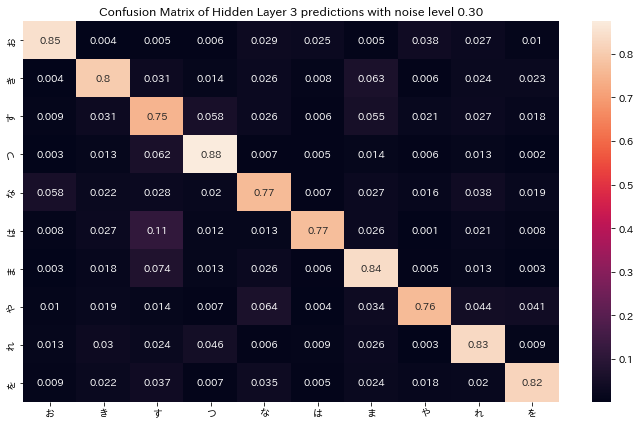

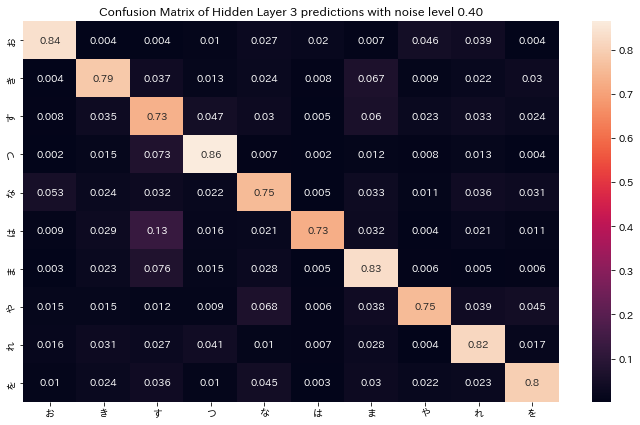

In [ ]:
for i in noise_lev:
  y_true = kmnist_test.targets.cpu().numpy() 
  y_pred = get_y_values_at_noise_level(i)[2]
  h3_predictions_indices = y_pred.max(axis=1).indices.cpu().numpy()   # convert probabilities to indices

  cf_mat = confusion_matrix(y_true, h3_predictions_indices)
  cf_mat_df = pd.DataFrame(cf_mat/np.sum(cf_mat) *10, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  plt.title("Confusion Matrix of Hidden Layer 3 predictions with noise level "+ str("{:.2f}".format(i)))
  sn.heatmap(cf_mat_df, annot=True)

### Feed-Forward Network 

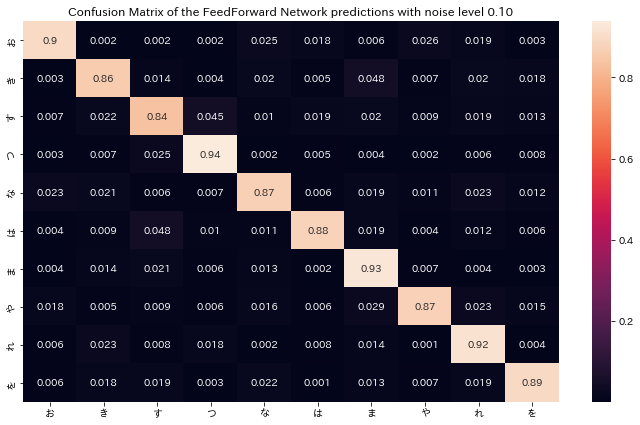

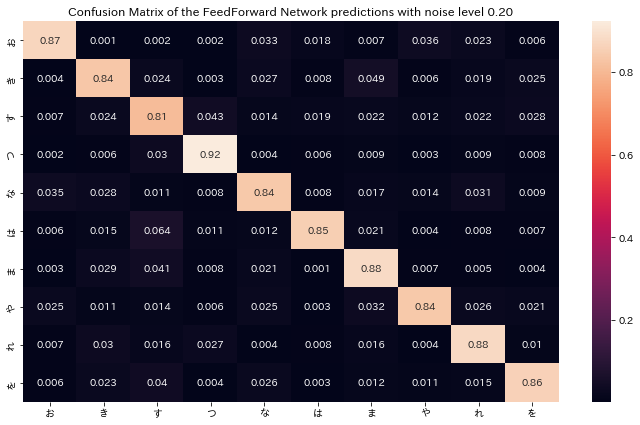

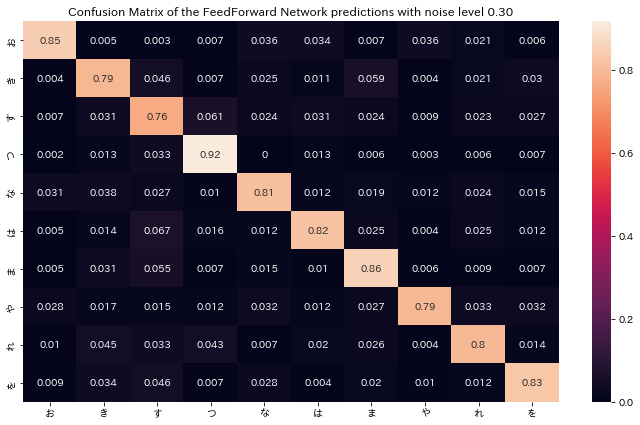

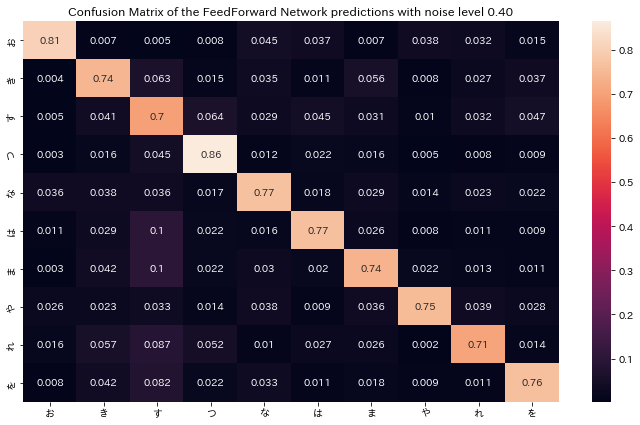

In [ ]:
for i in noise_lev:
  y_true = kmnist_test.targets.cpu().numpy() 
  y_pred = get_y_values_at_noise_level(i)[3]
  ffnn_predictions_indices = y_pred.max(axis=1).indices.cpu().numpy()  # convert probabilities to indices

  cf_mat = confusion_matrix(y_true, ffnn_predictions_indices)
  cf_mat_df = pd.DataFrame(cf_mat/np.sum(cf_mat) *10, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  plt.title("Confusion Matrix of the FeedForward Network predictions with noise level "+ str("{:.2f}".format(i)))
  sn.heatmap(cf_mat_df, annot=True)

# Adversarial Attacks with the Fast Gradient Sign method

The attack adjusts the input data to maximize the loss based on the same backpropagated gradients instead of working to minimize the loss by adjusting the weights based on the backpropagated gradients. (Source: [Adversarial Example Generation, Nathan Inkawhich](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html))

Each adversarial observation will be obtained as follows 

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

## Adversarial examples

Definition of a DBN model with a given read-out level

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_kmnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_kmnist = dbn_kmnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_kmnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_kmnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_kmnist, [linear1, linear2, linear3], readout_level=2)

## Performing an adversarial attack with a sample from the test set

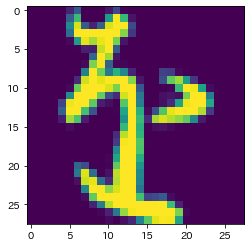

In [ ]:
test_sample_idx = 1
test_image = kmnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

### DBN with readout 

In [ ]:
attacked_model = dbn_with_readout
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the DBN for this clean sample is {prediction}.")

The prediction of the DBN for this clean sample is 9.


### FeedForward Network

In [ ]:
attacked_model = ffnn
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the FFNN for this clean sample is {prediction}.")

The prediction of the FFNN for this clean sample is 9.


## Creation and visualization of the corresponding adversarial example

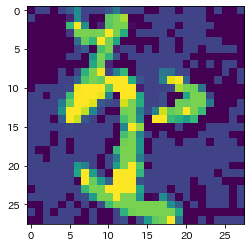

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = kmnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 6.


## Resistance to adversarial attacks

In order to see how the DBN performs, there will be a comparison between the DBN without the read-out and the DBN with the read-out whose task will also be to perform a reconstructed example with a one top-down reconstruction step.

In addition to that, there will be a comparison with the FFNN.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_kmnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.KMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

### Accuracy for the robustness to attack

#### FFNN

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 16.53%



#### DBN

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 43.62%



#### DBN with the use of one step of top-down reconstruction

With $ϵ=0.1$

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



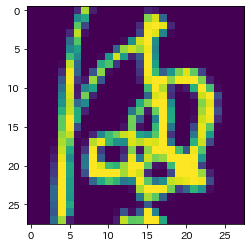


Here's a perturbed sample:



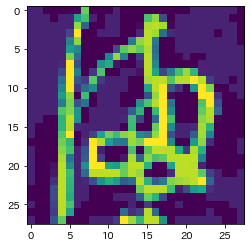


Here's what a 1-steps reconstructed sample looks like:



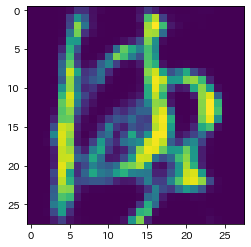


Epsilon: 0.1
Test Accuracy: 57.45%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Comparison of different values for the ϵ noise parameter

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1) #dbn with one step of top down reconstruction

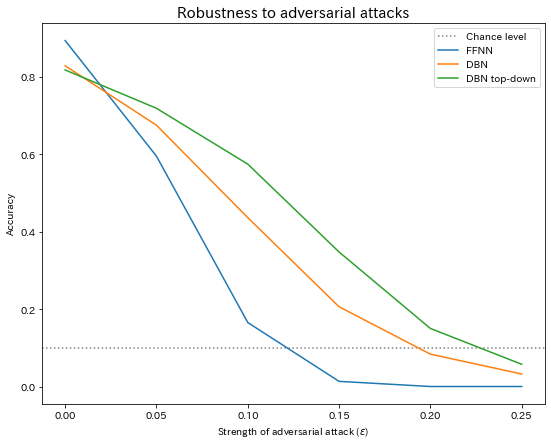

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

In conclusion, as the Strength of the adversarial attack increases, the DBN with the one-level read-out performs better that the DBN without the read-out. The Feed-Forward Network results the worst model with Adversarial Attacks compared to the other two, but also very bad in general.